## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [10]:
import math
import numpy as np
from numba import vectorize, f8

A = np.array([2, 5, 10, 3, 8], dtype=np.float64)

@vectorize([f8(f8)], target="parallel")
def log_numba(x):
    return math.log(x)

@vectorize([f8(f8)], target="parallel")
def exp_numba(x):
    return math.exp(x)

print("A =")
print(A)
print("\nlog(A) =")
print(log_numba(A))
print("\nexp(A) =")
print(exp_numba(A))

A =
[ 2.  5. 10.  3.  8.]

log(A) =
[0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]

exp(A) =
[7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [17]:
import math
import numpy as np
from numba import vectorize, f8
import timeit

mean, sigma = 1, 1
bound = (-3,3)
size = 100000

x = np.linspace(bound[0], bound[1], size)

@vectorize([f8(f8)], target="parallel")
def gauss(x):
    return 1/(math.sqrt(2*math.pi)*sigma) * math.exp(-math.pow(x-mean, 2)/(2*math.pow(sigma,2)))

# We now avoid to recalculate constants everytime

a = 1 / (math.sqrt(2*math.pi)*sigma)
b = - 1 / (2*math.pow(sigma,2))

@vectorize([f8(f8)], target="parallel")
def gauss_optimized(x):
    return a * math.exp(b*math.pow(x-mean, 2))

tic = timeit.default_timer()
print(gauss(x))
toc = timeit.default_timer()
print(f"That needed {toc-tic:.2e} seconds.")

print("\nNow an optimized version.")

tic = timeit.default_timer()
print(gauss_optimized(x))
toc = timeit.default_timer()
print(f"That needed {toc-tic:.2e} seconds.")

[0.00013383 0.00013386 0.00013389 ... 0.05400393 0.05399745 0.05399097]
That needed 8.85e-04 seconds.

Now an optimized version.
[0.00013383 0.00013386 0.00013389 ... 0.05400393 0.05399745 0.05399097]
That needed 5.11e-04 seconds.


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

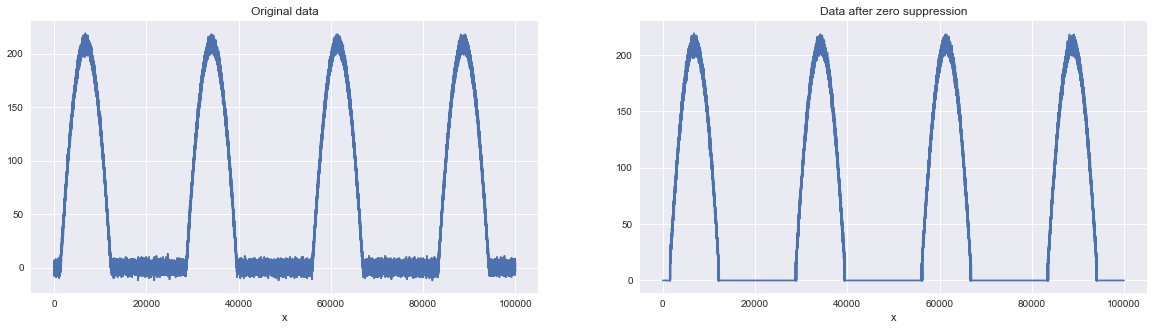

In [34]:
import math
from numba import vectorize, i2
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
threshold = 15

@vectorize([i2(i2)], target="parallel", nopython=True)
def suppress(x):
    return 0 if abs(x) < threshold else x

data_suppressed = suppress(data)

# Plotting
plt.style.use("seaborn")
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
X = np.arange(n)
ax[0].set_title("Original data")
ax[0].set_xlabel("x")
ax[0].plot(X, data)
ax[1].set_title("Data after zero suppression")
ax[1].set_xlabel("x")
_ = ax[1].plot(X, data_suppressed)

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [50]:
import math
from numba import njit, f8, prange

X = np.random.rand(3,3)
Y = np.random.rand(3,3)

a, c = 1, 3
K = np.zeros(X.shape[1])

@njit([(f8[:,:], f8[:,:], f8[:])], parallel=True)
def sigm(x, y, k):
    xt = x.T
    for i in prange(k.shape[0]):
        s = 0
        for j in prange(xt.shape[0]):
            s += xt[i,j]*y[j,i]
        k[i] = a * math.tanh(s) + c

sigm(X, Y, K)
print(K)

[3.27672975 3.5921998  3.81292668]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [55]:
import math
import numpy as np
from numba import cuda

n = 256
M = np.random.rand(n, n, n)

tpb = 1024
bpg = (M.size + tpb - 1) // tpb

result = M.copy()

@cuda.jit
def cos_cuda(m, out):
    x, y, z = cuda.grid(3)
    if x < m.shape[0] and y < m.shape[1] and z < m.shape[2]:
        out[x,y,z] = math.cos(m[x,y,z])

cos_cuda[bpg, tpb](M, result)

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [70]:
from __future__ import division
from numba import cuda
import numpy as np
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.rand(24, 12)
B = np.random.rand(12, 22)

# Configure the blocks
threadsperblock = (32, 32)
blockspergrid_x = (A.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (B.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((A.shape[0], B.shape[1]))
matmul[blockspergrid, threadsperblock](A, B, C)
assert(np.all(C == A@B))